# Лабораторная работа 4. Часть 2. Рекомендательные системы.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 8 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Рекеомендация организаций, которые получат высокий отзыв от пользователя, когда он гостит в чужом для себя городе

Эта лабораторная работа про задачу из соревнования

https://contest.yandex.ru/contest/32148/problems/
    


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

%matplotlib inline

**(1 балла) Задание 1.** Знакомство с данными.

В первую очередь нам понадобятся данные по __пользователям__ (в терминах recsys -- users), __организациям__ (в терминах recsys -- items) и сами __отзывы__ (в терминах recsys -- ratings или explicit feedback). 

На основании этих данных можно будет проводить базовый анализ методами колаборативной фильтрации.

  * Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.
  * Предложите стратегии фильтрации данных.
  


Во вторую очередь нас будут инетересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


##### Пользователи

In [11]:
users = pd.read_csv('./data/users.csv')
users.head()

,user_id,city
0,12735004856856244189,msk
1,13776338520332531455,msk
2,15114084219042454101,msk
3,18069716857179407490,msk
4,4630864276989162245,msk


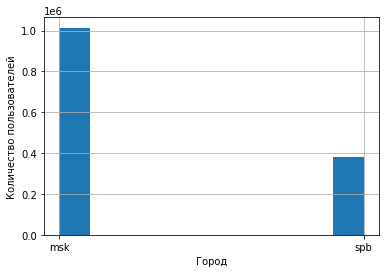

In [12]:
users['city'].hist()

plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

##### Организации

In [13]:
to_list = lambda nums: [int(num) for num in str(nums).split(' ')]

def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

In [14]:
orgs = pd.read_csv('./data/organisations.csv')

columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns, to_list)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,"[30776, 30774]","[3501685156, 3501779478, 20422, 3502045016, 35..."
1,16076540698036998306,msk,500.0,4.375000,[30771],"[1509, 1082283206, 273469383, 10462, 11617, 35..."
2,8129364761615040323,msk,500.0,4.000000,[31495],"[10462, 11177, 11617, 11629, 1416, 1018, 11704..."
3,15262729117594253452,msk,500.0,4.538813,"[30776, 30770]","[3501618484, 2020795524, 11629, 11617, 1018, 1..."
4,13418544315327784420,msk,500.0,4.409091,[31495],"[11617, 10462, 11177, 1416, 11867, 3501744275,..."


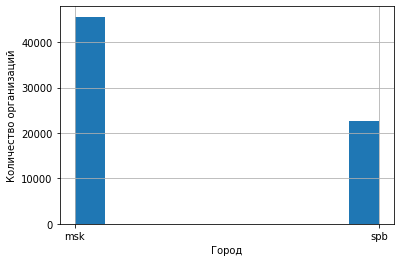

In [15]:
orgs.city.hist()

plt.xlabel('Город')
plt.ylabel('Количество организаций')
plt.show()

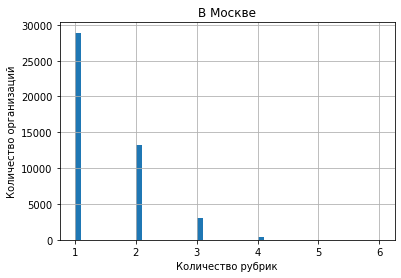

In [16]:
orgs[orgs.city == 'msk']['rubrics_id'].apply(lambda rubrics: len(rubrics)).hist(bins=50)

plt.title('В Москве')
plt.xlabel('Количество рубрик')
plt.ylabel('Количество организаций')
plt.show()

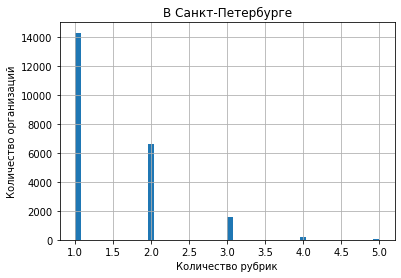

In [17]:
orgs[orgs.city == 'spb']['rubrics_id'].apply(lambda rubrics: len(rubrics)).hist(bins=50)

plt.title('В Санкт-Петербурге')
plt.xlabel('Количество рубрик')
plt.ylabel('Количество организаций')
plt.show()

Большинство организация имеет по одной рубрике. Так же организация в Москве больше, чем в Петербурге

##### Отзывы пользователей об организациях

In [25]:
reviews = pd.read_csv('./data/reviews.csv', low_memory=False)

reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city', 'rating': 'user_rating'}, axis=1)

reviews = reviews.merge(orgs[['org_id', 'city', 'average_bill', 'rating']], on='org_id')
reviews = reviews.rename({'city': 'org_city', 'rating': 'org_rating'}, axis=1)

apply_to_columns(reviews, ['aspects'], to_list)

reviews.head()

,user_id,org_id,user_rating,ts,aspects,user_city,org_city,average_bill,org_rating
0,5969205021826098131,15999570556361329805,1.0,279,NaN,spb,spb,500.0,4.42225
1,11419028914633614269,15999570556361329805,1.0,391,NaN,spb,spb,500.0,4.42225
2,11971839180212507821,15999570556361329805,1.0,419,NaN,spb,spb,500.0,4.42225
3,3849350083734153986,15999570556361329805,1.0,641,NaN,spb,spb,500.0,4.42225
4,6903065064138938065,15999570556361329805,1.0,654,NaN,spb,spb,500.0,4.42225


In [29]:
print("Количество отзывов по Москве:", reviews[reviews.org_city == 'msk'].shape[0])
print("Количество отзывов по Петербургу:", reviews[reviews.org_city == 'spb'].shape[0])

Количество отзывов по Москве: 2870455
Количество отзывов по Петербургу: 1259241


In [30]:
print("Количество отзывов по Москве от петербуржцев:", reviews[(reviews.org_city == 'msk') & (reviews.user_city == 'spb')].shape[0])
print("Количество отзывов по Петербургу от москвичей:", reviews[(reviews.org_city == 'spb') & (reviews.user_city == 'msk')].shape[0])

Количество отзывов по Москве от петербуржцев: 44470
Количество отзывов по Петербургу от москвичей: 167439


Количество отзывов от петербуржцев-туристов меньше, чем от москвичей-туристов. Что ж, мы любим Питер и едем туда на выходные, а петербуржцы любят Питер всегда (шутка) 😁 

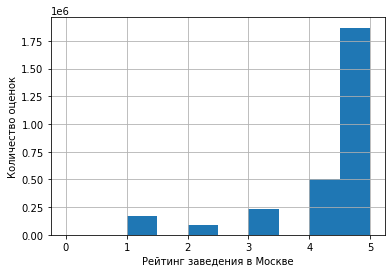

In [36]:
reviews[reviews.org_city == 'msk']['user_rating'].hist()

plt.xlabel('Рейтинг заведения в Москве')
plt.ylabel('Количество оценок')
plt.show()

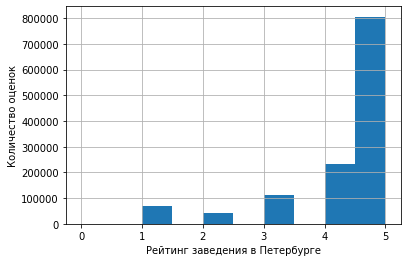

In [37]:
reviews[reviews.org_city == 'spb']['user_rating'].hist()

plt.xlabel('Рейтинг заведения в Петербурге')
plt.ylabel('Количество оценок')
plt.show()

  Посмотрим, какие оценки ставят москвичи

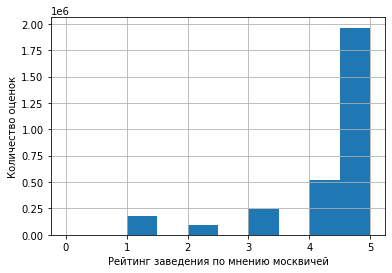

In [38]:
reviews[reviews.user_city == 'msk']['user_rating'].hist()

plt.xlabel('Рейтинг заведения по мнению москвичей')
plt.ylabel('Количество оценок')
plt.show()

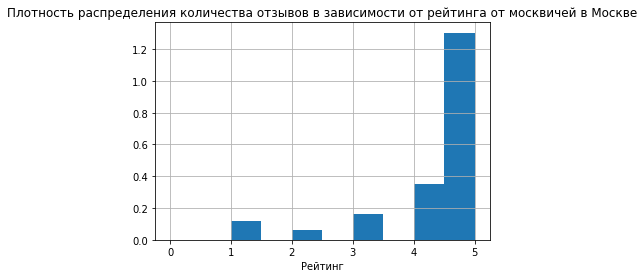

In [39]:
reviews[(reviews.user_city == 'msk') & (reviews.org_city == 'msk')]['user_rating'].hist(density=True)

plt.title('Плотность распределения количества отзывов в зависимости от рейтинга от москвичей в Москве')
plt.xlabel('Рейтинг')
plt.show()

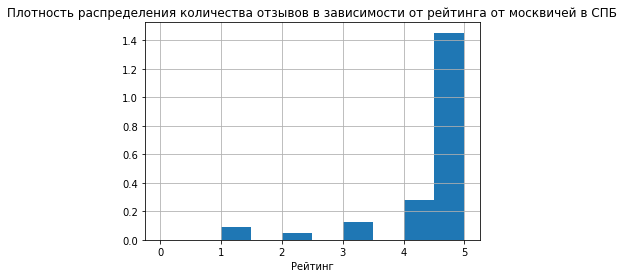

In [40]:
reviews[(reviews.user_city == 'msk') & (reviews.org_city == 'spb')]['user_rating'].hist(density=True)

plt.title('Плотность распределения количества отзывов в зависимости от рейтинга от москвичей в СПБ')
plt.xlabel('Рейтинг')
plt.show()

Москвичи чаще ставят оценки от 4,5 до 5 заведениям в СПБ, чем в МСК

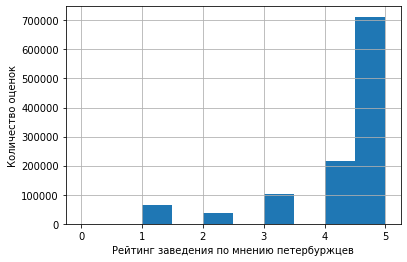

In [41]:
reviews[reviews.user_city == 'spb']['user_rating'].hist()

plt.xlabel('Рейтинг заведения по мнению петербуржцев')
plt.ylabel('Количество оценок')
plt.show()

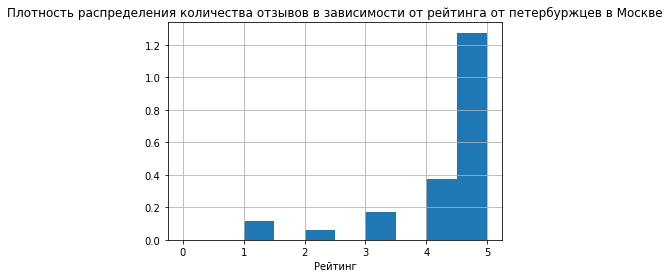

In [42]:
reviews[(reviews.user_city == 'spb') & (reviews.org_city == 'msk')]['user_rating'].hist(density=True)

plt.title('Плотность распределения количества отзывов в зависимости от рейтинга от петербуржцев в Москве')
plt.xlabel('Рейтинг')
plt.show()

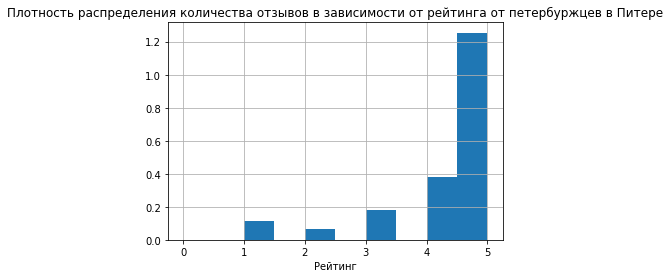

In [43]:
reviews[(reviews.user_city == 'spb') & (reviews.org_city == 'spb')]['user_rating'].hist(density=True)

plt.title('Плотность распределения количества отзывов в зависимости от рейтинга от петербуржцев в Питере')
plt.xlabel('Рейтинг')
plt.show()

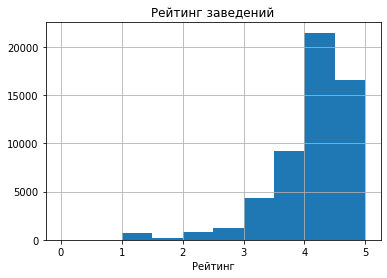

In [50]:
orgs['rating'].hist()

plt.title('Рейтинг заведений')
plt.xlabel('Рейтинг')
plt.show()

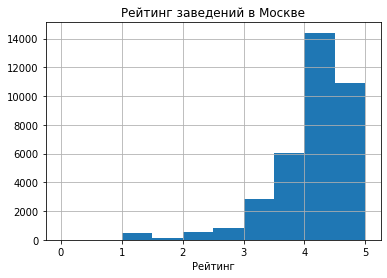

In [51]:
orgs[orgs.city == 'msk']['rating'].hist()

plt.title('Рейтинг заведений в Москве')
plt.xlabel('Рейтинг')
plt.show()

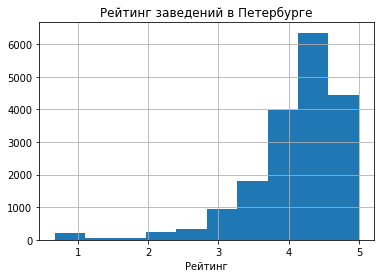

In [52]:
orgs[orgs.city == 'spb']['rating'].hist()

plt.title('Рейтинг заведений в Петербурге')
plt.xlabel('Рейтинг')
plt.show()

Больше всего организаций со средней оценкой от 4 до 4,5

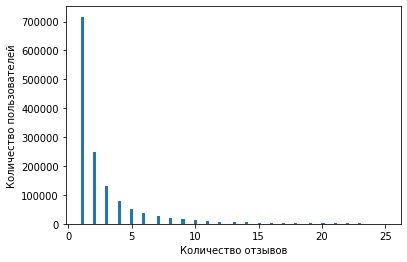

In [53]:
reviews.groupby('user_id')['user_id'].count().plot(kind='hist', bins=100, range=(1,25))

plt.xlabel('Количество отзывов')
plt.ylabel("Количество пользователей")
plt.show()

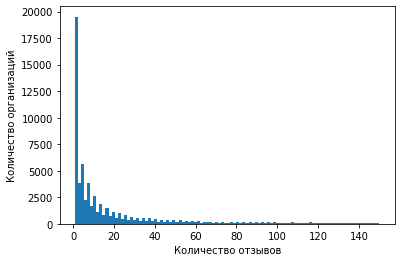

In [54]:
reviews.groupby('org_id')['user_id'].count().plot(kind='hist', bins=100, range=(1,150))

plt.xlabel('Количество отзывов')
plt.ylabel("Количество организаций")
plt.show()

Большинство пользователей оставляет от 1 до 5 отзывов на организации. За время собирания данных большинство организаций получает до 1 до 100 отзывов

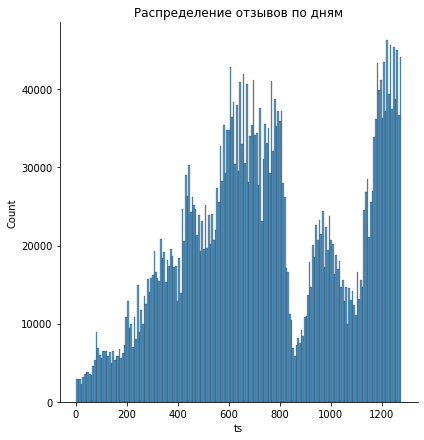

In [55]:
sns.displot(data=reviews, x='ts', height=6)
plt.title('Распределение отзывов по дням')
plt.show()

1) Можно попробовать пофильтровать заведения по рейтингу. Например, убрать заведения со средним рейтингом ниже 3. Таким образом система будет рекомендовать только заведения с хорошими отзывами. Однако, возможно, это не самый лучший вариант, тк может происходить накрутка отзывов + наверное, не совсем хорошо не рекомендовать отдельные организации  
2) Также можно попробовать убрать заведения у которых очень мало отзывов (но, если все отзывы хорошие, то этот вариант не кажется всегда успешным)

#####  Извлекаемые из отзывов аспекты (извлекается из отзыва с помощью NLP-алгоритма и может быть неточным)

In [56]:
aspects = pd.read_csv('./data/aspects.csv', low_memory=False)
aspects.head()

,aspect_id,aspect_name
0,1,Бургеры
1,2,Чистота
2,3,Интерьер
3,4,Еда
4,5,Напитки


##### Описание особенностей организаций

In [57]:
features = pd.read_csv('./data/features.csv', low_memory=False)
features.head()

,feature_id,feature_name
0,1,prepress_and_post_printing_processing
1,40,products
2,54,printing_method
3,77,fuel
4,79,shop


##### Описание рубрик организаций

In [58]:
rubrics = pd.read_csv('./data/rubrics.csv', low_memory=False)
rubrics.head()

,rubric_id,rubric_name
0,30519,"Булочная, пекарня"
1,30770,"Бар, паб"
2,30771,Быстрое питание
3,30774,Кафе
4,30775,Пиццерия


In [61]:
reviews.drop(columns=['aspects'], inplace=True)
reviews.head()

,user_id,org_id,user_rating,ts,user_city,org_city,average_bill,org_rating
0,5969205021826098131,15999570556361329805,1.0,279,spb,spb,500.0,4.42225
1,11419028914633614269,15999570556361329805,1.0,391,spb,spb,500.0,4.42225
2,11971839180212507821,15999570556361329805,1.0,419,spb,spb,500.0,4.42225
3,3849350083734153986,15999570556361329805,1.0,641,spb,spb,500.0,4.42225
4,6903065064138938065,15999570556361329805,1.0,654,spb,spb,500.0,4.42225


**(1 балла) Задание 2.** Организация валидации.

Как вы помните, обучающее множество собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

Следовательно нам необходимо организовать у себя валидацию схожим образом.
Раз мы будем еще и осуществлять выбор моделей, то следует произвести расщепление по времнеи на 3 группы train validation и holdout.

Как уже говрилось на семинаре, для повышения качества локальной валидации, можно сделать скользящую валидацию. В самой лабораторной работе мы так делат не будем, но для конкурса имейте это в виду.


In [62]:
print('Всего', reviews['ts'].max(), 'ts')

Всего 1277 ts


In [65]:
def train_test_split(df, ts):
    df_train = df[df['ts'] < ts]
    df_test = df[df['ts'] >= ts]
    
    df_test = df_test[df_test['user_rating'] >= 4.]
    df_test = df_test[df_test['user_city'] != df_test['org_city']]
    
    train_orgs = pd.DataFrame(df_train['org_id'].unique(), columns=['org_id'])
    train_users = pd.DataFrame(df_train['user_id'].unique(), columns=['user_id'])
    
    df_test = df_test.merge(train_orgs, how='inner', on='org_id')
    df_test = df_test.merge(train_users, how='inner', on='user_id')
    
    return df_train, df_test

In [66]:
reviews_train, reviews_test = train_test_split(reviews, 1100)

In [67]:
reviews_train.head()

,user_id,org_id,user_rating,ts,user_city,org_city,average_bill,org_rating
0,5969205021826098131,15999570556361329805,1.0,279,spb,spb,500.0,4.42225
1,11419028914633614269,15999570556361329805,1.0,391,spb,spb,500.0,4.42225
2,11971839180212507821,15999570556361329805,1.0,419,spb,spb,500.0,4.42225
3,3849350083734153986,15999570556361329805,1.0,641,spb,spb,500.0,4.42225
4,6903065064138938065,15999570556361329805,1.0,654,spb,spb,500.0,4.42225


In [68]:
reviews_test.head()

,user_id,org_id,user_rating,ts,user_city,org_city,average_bill,org_rating
0,17688156658868277259,8261552478212626697,5.0,1125,msk,spb,NaN,4.563694
1,17688156658868277259,1732348878070501516,5.0,1150,msk,spb,NaN,4.562938
2,17688156658868277259,411045512302840454,5.0,1213,msk,spb,500.0,4.436490
3,11814961351844939114,9370515323108518895,5.0,1122,msk,spb,NaN,4.488172
4,11814961351844939114,217458180450656997,5.0,1185,msk,spb,1000.0,4.351075


In [69]:
def get_rewiews(df):
    y = df.groupby('user_id')['org_id'].apply(list).reset_index(name='org_id')
    X = pd.DataFrame(df['user_id']).merge(users, on='user_id')
    
    return X, y

In [70]:
X_test, y_test = get_rewiews(reviews_test)

In [71]:
X_test.head()

,user_id,city
0,17688156658868277259,msk
1,17688156658868277259,msk
2,17688156658868277259,msk
3,11814961351844939114,msk
4,11814961351844939114,msk


In [72]:
y_test.head()

,user_id,org_id
0,208354737127838,[11710076672100157355]
1,274614850344222,"[13171633093209867072, 2085964966481486021, 79..."
2,522764259757895,[17351801057721420245]
3,1077250097574455,[1352900198295267165]
4,2282650864296040,"[3257931713419990933, 16486831410582745802]"


**(0.5 балла) Задание 3.** Базовые решения.

Сделаем базовые решения:
  * Для каждого пользователя выдаём 20 случайных организаций
  * Для каждого пользователя выдаём самые популярные организации в неродном городе

Напишем класс, который для каждого пользователя выдаёт 20 случайных организаций

In [73]:
class RandomChoice:
    def __init__(self, N=20):
        self.N = N
            
        self._spb_orgs = None
        self._msk_orgs = None
    
    def fit(self, X):
        self._spb_orgs = X[X['org_city'] == 'spb']['org_id'].unique()
        self._msk_orgs = X[X['org_city'] == 'msk']['org_id'].unique()
        return self
        
    def predict(self, X):
        choice = lambda x: np.random.choice(self._msk_orgs, 20) if x['city'] == 'spb' else np.random.choice(self._spb_orgs, 20)
        prediction = pd.concat((X['user_id'], X.apply(choice, axis=1)), axis=1).rename(columns={0: 'org_id'})
        return prediction

In [74]:
random_model = RandomChoice().fit(reviews_train)
y_pred = random_model.predict(X_test)

In [75]:
X_test.shape, y_pred.shape

((25290, 2), (25290, 2))

Напишем класс, который для каждого пользователя выдаёт самые популярные организации в неродном городе. Тк мы не хотим рекомендовать места с плохим рейтингом, будем считать, что популярные места == места с высоким рейтингом.

In [76]:
class PopularChoice:
    def __init__(self, min_rating=4.0, N=20):
        self.min_rating = min_rating
        self.N = N
        
        self._spb_orgs = None
        self._msk_orgs = None
    
    def fit(self, X):
        self._spb_orgs = X[(X['org_city'] == 'spb') & (X['org_rating'] >= self.min_rating)]['org_id']
        self._spb_orgs = self._spb_orgs.value_counts().index[:self.N].to_list()
        
        self._msk_orgs = X[(X['org_city'] == 'msk') & (X['org_rating'] >= self.min_rating)]['org_id']
        self._msk_orgs = self._msk_orgs.value_counts().index[:self.N].to_list()
        
        return self
        
    def predict(self, X):
        choice = lambda x: self._msk_orgs if x['city'] == 'spb' else self._spb_orgs
        prediction = pd.concat((X['user_id'], X.apply(choice, axis=1)), axis=1).rename(columns={0: 'org_id'})
        return prediction

In [77]:
random_model = PopularChoice().fit(reviews_train)
y_pred = random_model.predict(X_test)

**(1.0 балла) Задание 4.** Метрики качества.

Напомним, что у нас бинарная релевантнотсь на основе оценки вычисляется как предикат **оценка больше, чем 3**.

Реализуйте набор метрик качества (можете оборачивать внешние паекты):

    * MNAP@20 (как в описании соревнования)
    * HitRate ( = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе)
    * MRR@20 ( обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. )
    * Coverage (доля item-ов, учитываемых в рекомендациях)
    * Surprisal(см. ниже) 


### Surprisal
Посмотирм, насколько наши рекомендации хороши с точки зрения новизны для пользователя, в качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

Будем рассматривать собственную информацию item-а как меру его новизны.

$$selfInformation(i) = -\log_2 \frac{|u_i|}{|N|}$$, 
где 
$i$ - объект, $|N|$ - число взаимодействий в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом в обучающей выборке.

После подсчета собственной информации усредним значения собственной информации в рекомендациях пользователя.

Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u)@k = \frac{1}{k \cdot log_2 N} \sum_{j = 1}^{k}selfInformation(i_{u,j})$$

где $i_{u,j}$ это j-й объект, который мы порекомендововали пользователю.

Получившаяся метрика похожа на энтропию Шеннона:
$$H = - K \sum_{i\in R}{p_i log p_i}$$


Результа усредним по пользователям.

### Что нужно сделать
    
  * Создайте функцию, которая генерирует словарь с метриками, по предоставленному решению.

  * Оцените baseline-решения на валидации.

In [78]:
def MNAP(y_true, y_pred, n=20):
    y_merged = y_pred.merge(y_true, how='left', on='user_id', suffixes=('_pred', '_true'))
    
    def mnap_user(org_true, org_pred):
        weights = [0]
        for i, pred in enumerate(org_pred):
            cur_weight = weights[-1] + (1 if pred in org_true else 0)
            weights.append(cur_weight)
        
        user_score = 0.
        for i, pred in enumerate(org_pred):
            if pred in org_true:
                user_score += weights[i + 1] / (i + 1)
        
        return user_score / min(n, len(org_true))
    
    return np.mean([mnap_user(row['org_id_true'], row['org_id_pred']) for _, row in y_merged.iterrows()])

In [79]:
def HitRate(y_true, y_pred):
    y_merged = y_pred.merge(y_true, how='left', on='user_id', suffixes=('_pred', '_true'))
    hitrate = y_merged[['org_id_pred', 'org_id_true']].apply(lambda x: 1 if set(x[0]) & set(x[1]) else 0, axis=1).mean()
    return hitrate

In [80]:
def MRR(y_true, y_pred, n=20):
    y_merged = y_pred.merge(y_true, how='left', on='user_id', suffixes=('_pred', '_true'))
    
    def mrr_user(org_true, org_pred):
        for i, pred in enumerate(org_pred):
            if pred in org_true:
                return 1 / (i + 1)
        return 0
    
    return np.mean([mrr_user(row['org_id_true'], row['org_id_pred']) for _, row in y_merged.iterrows()])

In [81]:
def coverage(y_true, y_pred):
    y_merged = y_pred.merge(y_true, how='left', on='user_id', suffixes=('_pred', '_true'))
    return np.mean([len(set(row['org_id_true']) & set(row['org_id_pred'])) / (len(set(row['org_id_true'])) + 1e-6) for _, row in y_merged.iterrows()])

In [82]:
def measure(pred, true, name, df=None, k=20):
    if df is None:
        df = pd.DataFrame(columns=['MNAP@k', 'hit_rate@k', 'mrr@k'])
    df.loc[name, 'MNAP@k'] = MNAP(true, pred)
    df.loc[name, 'hit_rate@k'] = HitRate(true, pred)
    df.loc[name, 'mrr@k'] = MRR(true, pred)
    
    return df

In [83]:
random_model = RandomChoice().fit(reviews_train)
y_pred = random_model.predict(X_test)

metrics = measure(y_pred, y_test, "Random Choise model")
metrics.head()

,MNAP@k,hit_rate@k,mrr@k
Random Choise model,9.78508e-05,0.00237248,0.000473075


In [84]:
random_model = PopularChoice().fit(reviews_train)
y_pred = random_model.predict(X_test)

metrics = measure(y_pred, y_test, "Popular Choise model",  df=metrics)
metrics.head()

,MNAP@k,hit_rate@k,mrr@k
Random Choise model,9.78508e-05,0.00237248,0.000473075
Popular Choise model,0.0365938,0.231949,0.0914612


**(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.
                                 
              
За последние годы было создано много библиотек для реализации алгоримтов построения рекомендаций.      
  * https://github.com/benfred/implicit
  * https://sberbank-ai-lab.github.io/RePlay/index.html
  * https://github.com/apple/turicreate 
  * https://github.com/caserec/CaseRecommender

Выеберите одну из них и постройте предсказания на основании совместной фильтрации по близости пользователей или по близости объектов.

Если обучение идёт слишком долго подумайте про семплирование данных. Обоснуйте выбранную стратегию семплирования.



## Методы Matrix factorization

**(0.5 балла) Задание 6.**

- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
   * Получив векторные представления пользователей и объектов и сингулярные числа, мы можеи восстановив матрицу и в местах нулей получим "предсказанные значения вероятностей" для новых объектов.
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

**(1.0 балла) Задание 7.**
Примените ALS.

Можно воспользоваться готовой реализацией из бибилотеки https://github.com/benfred/implicit

Попробуйте использовать как все оценки, так и только высокие. Есть ли разница?

**(1.0 балла) Задание 8.**

На [семинаре](https://github.com/monkey0head/recsys_sem) Вам было расказано про бибилиотеку LightFM.
Примените ее для нашей задачи.

In [85]:
!pip install lightfm

     |████████████████████████████████| 310 kB 5.5 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705381 sha256=2c82117a54aef9712797a1a6993843309febe5c9851ca7315591a3e4bac16b13
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [86]:
from lightfm import LightFM
from lightfm.data import Dataset

In [88]:
reviews_train.head()

,user_id,org_id,user_rating,ts,user_city,org_city,average_bill,org_rating
0,5969205021826098131,15999570556361329805,1.0,279,spb,spb,500.0,4.42225
1,11419028914633614269,15999570556361329805,1.0,391,spb,spb,500.0,4.42225
2,11971839180212507821,15999570556361329805,1.0,419,spb,spb,500.0,4.42225
3,3849350083734153986,15999570556361329805,1.0,641,spb,spb,500.0,4.42225
4,6903065064138938065,15999570556361329805,1.0,654,spb,spb,500.0,4.42225


In [89]:
lfm_dataset = Dataset()
lfm_dataset.fit_partial(users=reviews_train['user_id'].unique(), items=reviews_train['org_id'].unique())
# lfm_dataset.fit_partial(user_features=unique_user_tags, item_features=unique_item_tags)

In [90]:
user_mapping = lfm_dataset.mapping()[0]
user_f_mapping = lfm_dataset.mapping()[1]
item_mapping = lfm_dataset.mapping()[2]
item_f_mapping = lfm_dataset.mapping()[3]

In [142]:
inv_user_mapping = {value: key for key, value in user_mapping.items()}
inv_item_mapping = {value: key for key, value in item_mapping.items()}

In [125]:
spb_orgs = reviews_train[reviews_train['org_city'] == 'spb']['org_id'].unique()
msk_orgs = reviews_train[reviews_train['org_city'] == 'msk']['org_id'].unique()

In [141]:
spb_item_mapping = {org_id: map_id for org_id, map_id in item_mapping.items() if org_id in spb_orgs}
msk_item_mapping = {org_id: map_id for org_id, map_id in item_mapping.items() if org_id in msk_orgs}

In [147]:
users[users.user_id == 5969205021826098131]['city'].values[0]

'spb'

In [96]:
%%time
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.org_id, row.user_rating) for row in reviews_train.itertuples()])

CPU times: user 30.6 s, sys: 592 ms, total: 31.2 s
Wall time: 33.2 s


In [97]:
%%time
lightfm = LightFM(no_components=64, loss='warp', random_state=453)
lightfm.fit(interactions, epochs=40, num_threads=8)

CPU times: user 12min 54s, sys: 1.25 s, total: 12min 55s
Wall time: 7min 20s


In [154]:
from tqdm import tqdm

y_pred = []
for user_id in tqdm(y_test['user_id']):
    user_city = users[users.user_id == user_id]['city'].values[0]
    user_item_mapping = msk_item_mapping if user_city == 'spb' else spb_item_mapping

    pred = lightfm.predict(user_ids=user_mapping[user_id], item_ids=sorted(user_item_mapping.values()))
    ids = np.argpartition(pred, -20)[-20:]
    rel = pred[ids]
    res = pd.DataFrame(zip(ids, rel), columns=['org_id', 'user_rating'])
    res['org_id'] = res['org_id'].map(inv_item_mapping)
    y_pred.append(res['org_id'])

100%|██████████| 14663/14663 [26:45<00:00,  9.13it/s]


In [191]:
df = pd.DataFrame()
df['user_id'] = y_test['user_id']
df = pd.concat((df, pd.DataFrame([" ".join(list(map(str, y))) for y in y_pred])), axis=1).rename(columns={0: 'org_id'})
apply_to_columns(df, ['org_id'], to_list)
df.head()

,user_id,org_id
0,208354737127838,"[12411544837013570287, 18003672505940196359, 6..."
1,274614850344222,"[15702812398490905957, 4792599034449798783, 63..."
2,522764259757895,"[8320990031460298552, 15838187834615056282, 11..."
3,1077250097574455,"[6087008197288791843, 11123004134395086060, 52..."
4,2282650864296040,"[15618502099323649833, 426965047563353852, 102..."


In [193]:
measure(df, y_test, "LightFM model", df=metrics)

,MNAP@k,hit_rate@k,mrr@k
Random Choise model,9.78508e-05,0.00237248,0.000473075
Popular Choise model,0.0365938,0.231949,0.0914612
LightFM model,0.00127805,0.0120712,0.00205025


**(1.0 балла) Задание 9.**

   Посмотрим на все прошлые методы как на модели, которые генерируют нам кандидатов для ответа рекомендательной системы. 
   
   Как нам выбрать те 20 организаций наилучшим образом? 
   
   Давайте подключим машинное обучение. Сформуллируем задачу ранжирования: запросом будет пользователь. Документами будут организации. Наивным призаковым описанием будет, например, факт рекомендации данной органицзаии методом SVD, ALS, LightFM.
   Примените catboost для создания переранжирования рекомендаций.